<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/1d_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal:
- implement 1d classification a la Nelson, 2019

# TODO:
- learn noise parameter `sigma_noise`
- speed up with convolution implementation (verify matched explicit implementation)

# Generate fake data

In [0]:
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt


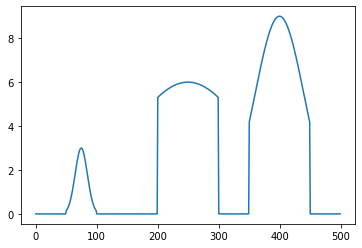

In [23]:
N = 500
M=250
sigma = 3
A = np.zeros(N)
span=50
std=10
A[1*span:2*span] = 3*scipy.signal.gaussian(1*span,1*std)
A[4*span:6*span] = 6*scipy.signal.gaussian(2*span,10*std,)
A[7*span:9*span] = 9*scipy.signal.gaussian(2*span,4*std)
pd.Series(A).plot()

In [0]:
def shift_zeropad(x,shift):
  if np.isclose(shift, 0): return(x)
  
  x = np.roll(x,shift)
  if shift > 0:
    x[:shift] = 0
  else:
    x[shift:] = 0
  
  return(x)

In [0]:
def make_fake(A,sigma,sigma_shift,return_shift=False):
  shift = np.ceil(sigma_shift*np.random.normal()).astype(int)
  x=shift_zeropad(A,shift)
  x += sigma*np.random.normal(size=A.shape)
  if return_shift: return(x,shift)
  else: return(x)


array([  47,   -4,  -22,   12,   25, -120,   85,   45,   31,   88,  -71,
         51,  -35,   -9,  -61,  120,  -63,   14,  -28,   35,  -71,  137,
         43,  -34,  149,  -23,   36,   32,  -62,  -57,   -9,    6,  -43,
         51,   88,   -5,   20,   31, -162,  -60,   37,  -30,  -38,  -10,
         51,  -67,   28,   -9,  -58,   17,  -53,  -78,  -42,  -19,  -59,
          8,   15,  -47,   79,   36,  -57,   32,    4,   39,  -73,   12,
          6,  -30,  -62,  -85,   40,   10,   62,   64,  -77, -119,   17,
        -31,   59,  -32,   -7,  -48,  103,  -96,  -13,  -44,   16,   33,
         40,  -15,  -31,    8,    9,   73,   17,   21,  -44,   56,   26,
         99,   29,  -47,   -6,   -1,   35,  -13,  -16,  -84,   -7,   23,
        -33,  130,  -58,  -24,  -18,  -42,  -91,   85,   79,  -62,   18,
         75,   38,   55,  -15,   53,    0,   61,   40,   56,  -51,  -89,
         34,  -67,   45,  -33,    2,   43,   24,   56,  -63,  -22,   14,
        -60,   54,   28,  -36,  -32,  -13,  -44,   

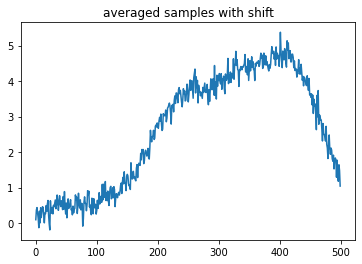

In [24]:
sigma_shift=50
X = np.zeros((M,N))
true_shifts = np.zeros(M,dtype=np.int32)
for i in range(M):
  X[i,:], true_shifts[i] = make_fake(A.copy(),sigma,sigma_shift=sigma_shift,return_shift=True)

pd.Series(X.mean(0)).plot(title='averaged samples with shift') 
true_shifts

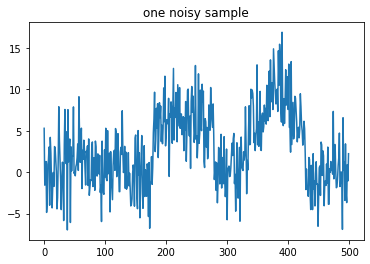

In [25]:
pd.Series(X[2]).plot(title='one noisy sample')

# Build equations for algorithm
- table of shifted A
- table of norms of shifted A
- table of pdf of shifts
- loop over samples
  - corr shift A,x; for all x in X
  - compute gi
  - sum over u to get norm factor U
  - accumulate log likelihood
- reverse shift
- sum over i
- update A

## table of shifted A

In [0]:
A_prev = X.mean(0)
shifts = np.arange(-N,N+1, dtype=np.int32)


In [0]:
A_shifted = np.zeros((shifts.shape[0],N))
for shift_idx,shift in enumerate(shifts):
  A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

##table of norms of shifted A

In [0]:

A_shifted_norm = np.linalg.norm(A_shifted,axis=1)

## table of pdf of shifts

In [0]:
shift_pdf = np.zeros(shifts.shape)
for idx,s in enumerate(shifts): 
  shift_pdf[idx] = scipy.stats.norm.pdf(s)#np.exp(-s**2/2)*(2*np.pi)**-0.5


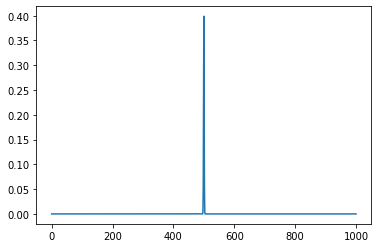

In [12]:
pd.Series(shift_pdf).plot()

## corr shift A,x; for all x in X exponentiate for gi

In [0]:
x = X[0]
corr_A_x = np.zeros(A_shifted.shape[0])
for idx,a_shifted in enumerate(A_shifted):
  corr_A_x[idx] = np.multiply(a_shifted,x).sum()
corr_A_x *= sigma**-2

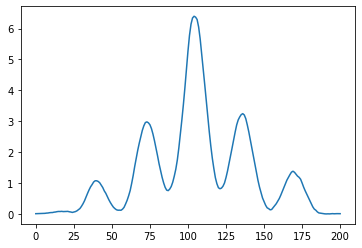

In [324]:
pd.Series(corr_A_x).plot()

In [0]:
A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
corr_A_x_ = sigma**-2*corr_A_x
Ki = max(corr_A_x_.max(),A_shifted_norm_.max()) # for numerical stability?

gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

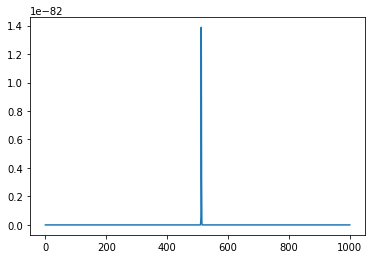

In [15]:
pd.Series(gi).plot()

## sum over u to get norm factor U

In [16]:
Ui = gi.sum()**-1
Ui

5.519528419470471e+81

## accumulate loglikelihood

In [17]:
-np.log(Ui) # sigma factor missing, same for all i

-188.2176849579019

## reverse shift

In [0]:
x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
for shift_idx,shift in enumerate(shifts):
  x_shifted[shift_idx,:] = shift_zeropad(x,shift) # have to reverse shift?

In [19]:
x_shifted.shape

(1001, 500)

In [0]:
a=0
conv_i = np.multiply(gi,x_shifted[:,a]).sum() 

In [348]:
#scipy.signal.convolve(range(10),range(10),mode='same')

array([ 10,  20,  35,  56,  84, 120, 165, 200, 224, 236])

In [349]:
#scipy.ndimage.convolve(range(10),range(10),mode='constant')

array([ 20,  35,  56,  84, 120, 165, 200, 224, 236, 235])

In [350]:
#scipy.ndimage.convolve1d(range(10),range(10),mode='constant')

array([ 20,  35,  56,  84, 120, 165, 200, 224, 236, 235])

In [381]:
Ui*conv_i

0.14151956676158675

# sum over i to get A next
- per pixel
- have to put together steps from before

In [0]:
# initialize

A_prev = X.mean(0)
shifts = np.arange(-N,N+1, dtype=np.int32)
A_next = A_prev.copy()

#idx_rand = np.arange(X.shape[0],dtype=np.int32)

i = 0, ll = -2586.47, A_next max = 12.48
i = 25, ll = -64964.66, A_next max = 216.52
i = 50, ll = -129614.87, A_next max = 438.53
i = 75, ll = -194559.17, A_next max = 662.82
i = 100, ll = -258775.83, A_next max = 889.31
i = 125, ll = -322636.04, A_next max = 1103.99
i = 150, ll = -388177.20, A_next max = 1336.53
i = 175, ll = -451394.53, A_next max = 1547.03
i = 200, ll = -515543.84, A_next max = 1776.38
i = 225, ll = -577987.42, A_next max = 1978.72
i = 0, ll = -2590.12, A_next max = 11.70
i = 25, ll = -64618.75, A_next max = 223.58
i = 50, ll = -128940.11, A_next max = 454.79
i = 75, ll = -193667.10, A_next max = 689.14
i = 100, ll = -257653.65, A_next max = 926.08
i = 125, ll = -321289.36, A_next max = 1136.07
i = 150, ll = -386664.17, A_next max = 1373.06
i = 175, ll = -449668.79, A_next max = 1595.68
i = 200, ll = -513593.40, A_next max = 1828.79
i = 225, ll = -575733.30, A_next max = 2039.86
i = 0, ll = -2577.82, A_next max = 12.07
i = 25, ll = -64276.44, A_next max = 222.10
i =

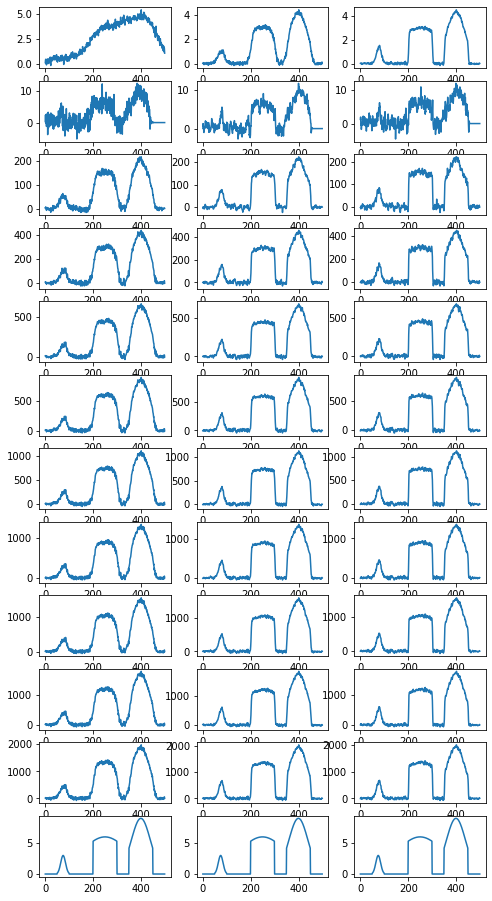

In [27]:
n_A_updates=3
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))


for c in range(n_A_updates):
  

  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  pd.Series(A_prev).plot(ax=axes[0,c])

  # shift A
  A_shifted = np.zeros((shifts.shape[0],N))
  for shift_idx,shift in enumerate(shifts):
    A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

  # norm A
  A_shifted_norm = np.linalg.norm(A_shifted,axis=1)**2

  # pdf shifts
  shift_pdf = np.zeros(shifts.shape)
  for idx,s in enumerate(shifts): 
    shift_pdf[idx] = np.exp(-s**2/(2*sigma_shift**2))*(2*np.pi)**-0.5#scipy.stats.norm.pdf(s,)#

  r=0
  best_shifts = np.zeros_like(true_shifts)

  idx_rand = np.arange(X.shape[0],dtype=np.int32)

  #np.random.shuffle(idx_rand)

  for i,x in enumerate(X):

    # corr
    corr_A_x = np.zeros(A_shifted.shape[0])
    for idx,a_shifted in enumerate(A_shifted):
      corr_A_x[idx] = np.multiply(a_shifted,x).sum()
    best_shifts[i] = np.argmax(corr_A_x) - (N + 1)
    
    # gi
    A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
    corr_A_x_ = sigma**-2*corr_A_x
    Ki = np.max(corr_A_x_ + A_shifted_norm_) # for numerical stability?

    gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev shift
    x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
    for shift_idx,shift in enumerate(shifts):
      x_shifted[shift_idx,:] = shift_zeropad(x,-shift) # have to reverse shift?

    conv = np.zeros(A_prev.shape[0])
    for A_idx in range(A_prev.shape[0]):
    # sum over shifts
      conv[A_idx] = np.multiply(gi,x_shifted[:,A_idx]).sum()
      #print(conv_i)

    #
      A_next[A_idx] += Ui*conv[A_idx] # perhaps accumulate and sum later... maybe better numerical stability
    
    if i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

  A_next *= N**-1
  pd.Series(A).plot(ax=axes[r+1,c])

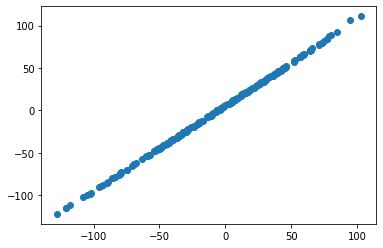

In [966]:
plt.scatter(best_shifts,true_shifts)